# 06 - Results Comparison and Analysis
## TCI6313 Computational Intelligence Project
### Comparative Evaluation of All CI Models

---

**Objective:** Compare and analyze the performance of all four CI models.

**Models Compared:**
1. **ANN Baseline** - Feedforward Neural Network (Neural Networks)
2. **LSTM** - Long Short-Term Memory Network (Deep Neural Networks)
3. **GA-ANN** - Genetic Algorithm Optimized ANN (Evolutionary Computation + NN)
4. **Fuzzy FIS** - Mamdani Fuzzy Inference System (Fuzzy Systems)

In [21]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import sys
import warnings

sys.path.append(os.path.abspath('../src'))

from evaluation import (
    compare_models, plot_model_comparison,
    load_results_from_json, compute_rmse, compute_mae, compute_r2
)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load All Results

In [22]:
# Load results from all models
RESULTS_DIR = '../results'

try:
    ann_results = load_results_from_json(os.path.join(RESULTS_DIR, 'ann_baseline_results.json'))
    print("✓ ANN results loaded")
except FileNotFoundError:
    print("✗ ANN results not found - run notebook 02 first")
    ann_results = None

try:
    lstm_results = load_results_from_json(os.path.join(RESULTS_DIR, 'lstm_results.json'))
    print("✓ LSTM results loaded")
except FileNotFoundError:
    print("✗ LSTM results not found - run notebook 03 first")
    lstm_results = None

try:
    ga_results = load_results_from_json(os.path.join(RESULTS_DIR, 'ga_ann_results.json'))
    print("✓ GA-ANN results loaded")
except FileNotFoundError:
    print("✗ GA-ANN results not found - run notebook 04 first")
    ga_results = None

try:
    fuzzy_results = load_results_from_json(os.path.join(RESULTS_DIR, 'fuzzy_results.json'))
    print("✓ Fuzzy FIS results loaded")
except FileNotFoundError:
    print("✗ Fuzzy results not found - run notebook 05 first")
    fuzzy_results = None

✓ ANN results loaded
✓ LSTM results loaded
✓ GA-ANN results loaded
✓ Fuzzy FIS results loaded


## 2. Performance Comparison Table

### ⚠️ Important Note on Data Fairness

LSTM models use sliding windows, which reduces the number of test samples:
- **ANN/GA-ANN**: Uses all 139 test samples
- **LSTM**: Uses 115 test samples (loses 24 due to sequence_length=24)

For fair comparison, we also compute metrics on **matching samples** in Section 2.1.

In [23]:
# Create comparison DataFrame
comparison_data = []

if ann_results:
    comparison_data.append({
        'Model': 'ANN Baseline',
        'RMSE': ann_results['metrics']['test']['rmse'],
        'MAE': ann_results['metrics']['test']['mae'],
        'R²': ann_results['metrics']['test']['r2'],
        'Training Time (s)': ann_results['training_time']
    })

if lstm_results:
    comparison_data.append({
        'Model': 'LSTM',
        'RMSE': lstm_results['metrics']['test']['rmse'],
        'MAE': lstm_results['metrics']['test']['mae'],
        'R²': lstm_results['metrics']['test']['r2'],
        'Training Time (s)': lstm_results['training_time']
    })

if ga_results:
    comparison_data.append({
        'Model': 'GA-ANN (Hybrid)',
        'RMSE': ga_results['metrics']['test']['rmse'],
        'MAE': ga_results['metrics']['test']['mae'],
        'R²': ga_results['metrics']['test']['r2'],
        'Training Time (s)': ga_results['total_time']
    })

if fuzzy_results:
    comparison_data.append({
        'Model': 'Fuzzy FIS',
        'RMSE': fuzzy_results['metrics']['test']['rmse'],
        'MAE': fuzzy_results['metrics']['test']['mae'],
        'R²': fuzzy_results['metrics']['test']['r2'],
        'Training Time (s)': fuzzy_results.get('inference_time', 0.05)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('RMSE')

print("="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

MODEL PERFORMANCE COMPARISON
          Model     RMSE      MAE       R²  Training Time (s)
   ANN Baseline 0.802393 0.591412 0.990041          27.513826
GA-ANN (Hybrid) 1.023161 0.660823 0.983806        2357.230209
      Fuzzy FIS 4.026600 2.920538 0.748536           0.048910
           LSTM 5.714050 4.073210 0.481264          81.100745


In [24]:
# Calculate improvement percentages
if len(comparison_data) >= 2:
    baseline_rmse = comparison_df[comparison_df['Model'] == 'ANN Baseline']['RMSE'].values[0] if 'ANN Baseline' in comparison_df['Model'].values else None
    
    if baseline_rmse:
        print("\n" + "="*50)
        print("IMPROVEMENT OVER ANN BASELINE")
        print("="*50)
        
        for _, row in comparison_df.iterrows():
            if row['Model'] != 'ANN Baseline':
                improvement = ((baseline_rmse - row['RMSE']) / baseline_rmse) * 100
                print(f"{row['Model']}: {improvement:+.2f}% RMSE change")
        print("="*50)


IMPROVEMENT OVER ANN BASELINE
GA-ANN (Hybrid): -27.51% RMSE change
Fuzzy FIS: -401.82% RMSE change
LSTM: -612.13% RMSE change


### 2.1 Fair Comparison (Same Test Samples)

To ensure academic fairness, we compare all models on the **same time points** that LSTM can predict.

In [25]:
# Fair Comparison: Evaluate all models on the SAME test samples
# LSTM has 115 samples, so we use the LAST 115 samples from ANN/GA-ANN predictions

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("="*70)
print("FAIR COMPARISON: Same Test Samples (Last 115 time points)")
print("="*70)

# Get LSTM sample count as reference
lstm_n_samples = lstm_results['metrics']['test']['n_samples'] if lstm_results else 115

fair_comparison_data = []

# Recalculate ANN metrics on matching samples
if ann_results and 'predictions' in ann_results:
    y_actual = np.array(ann_results['predictions']['test_actual'])[-lstm_n_samples:]
    y_pred = np.array(ann_results['predictions']['test_predicted'])[-lstm_n_samples:]
    
    fair_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    fair_mae = mean_absolute_error(y_actual, y_pred)
    fair_r2 = r2_score(y_actual, y_pred)
    
    fair_comparison_data.append({
        'Model': 'ANN Baseline',
        'RMSE (Fair)': fair_rmse,
        'MAE (Fair)': fair_mae,
        'R² (Fair)': fair_r2,
        'N Samples': lstm_n_samples
    })
    print(f"ANN (recalculated on {lstm_n_samples} samples): RMSE={fair_rmse:.4f}, R²={fair_r2:.4f}")

# LSTM - use original metrics (already on 115 samples)
if lstm_results:
    fair_comparison_data.append({
        'Model': 'LSTM',
        'RMSE (Fair)': lstm_results['metrics']['test']['rmse'],
        'MAE (Fair)': lstm_results['metrics']['test']['mae'],
        'R² (Fair)': lstm_results['metrics']['test']['r2'],
        'N Samples': lstm_results['metrics']['test']['n_samples']
    })
    print(f"LSTM (original {lstm_results['metrics']['test']['n_samples']} samples): RMSE={lstm_results['metrics']['test']['rmse']:.4f}, R²={lstm_results['metrics']['test']['r2']:.4f}")

# Recalculate GA-ANN metrics on matching samples
if ga_results and 'predictions' in ga_results:
    y_actual = np.array(ga_results['predictions']['test_actual'])[-lstm_n_samples:]
    y_pred = np.array(ga_results['predictions']['test_predicted'])[-lstm_n_samples:]
    
    fair_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    fair_mae = mean_absolute_error(y_actual, y_pred)
    fair_r2 = r2_score(y_actual, y_pred)
    
    fair_comparison_data.append({
        'Model': 'GA-ANN (Hybrid)',
        'RMSE (Fair)': fair_rmse,
        'MAE (Fair)': fair_mae,
        'R² (Fair)': fair_r2,
        'N Samples': lstm_n_samples
    })
    print(f"GA-ANN (recalculated on {lstm_n_samples} samples): RMSE={fair_rmse:.4f}, R²={fair_r2:.4f}")

# Fuzzy FIS - use original metrics (evaluated on all test samples)
if fuzzy_results:
    fair_comparison_data.append({
        'Model': 'Fuzzy FIS',
        'RMSE (Fair)': fuzzy_results['metrics']['test']['rmse'],
        'MAE (Fair)': fuzzy_results['metrics']['test']['mae'],
        'R² (Fair)': fuzzy_results['metrics']['test']['r2'],
        'N Samples': fuzzy_results['metrics']['test']['n_samples']
    })
    print(f"Fuzzy FIS ({fuzzy_results['metrics']['test']['n_samples']} samples): RMSE={fuzzy_results['metrics']['test']['rmse']:.4f}, R²={fuzzy_results['metrics']['test']['r2']:.4f}")

# Create fair comparison DataFrame
if len(fair_comparison_data) > 0:
    fair_df = pd.DataFrame(fair_comparison_data)
    fair_df = fair_df.sort_values('RMSE (Fair)')
    
    print("\n" + "="*70)
    print("FAIR COMPARISON TABLE")
    print("="*70)
    print(fair_df.to_string(index=False))
    print("="*70)
    
    print("\n📊 Note: Fuzzy FIS uses rule-based inference (no training required)")
    print("   • ANN/GA-ANN/LSTM: Data-driven learning models")
    print("   • Fuzzy FIS: Knowledge-based expert system")

FAIR COMPARISON: Same Test Samples (Last 115 time points)
ANN (recalculated on 115 samples): RMSE=0.8440, R²=0.9887
LSTM (original 115 samples): RMSE=5.7141, R²=0.4813
GA-ANN (recalculated on 115 samples): RMSE=1.0962, R²=0.9809
Fuzzy FIS (138 samples): RMSE=4.0266, R²=0.7485

FAIR COMPARISON TABLE
          Model  RMSE (Fair)  MAE (Fair)  R² (Fair)  N Samples
   ANN Baseline     0.844009    0.621920   0.988682        115
GA-ANN (Hybrid)     1.096157    0.705545   0.980910        115
      Fuzzy FIS     4.026600    2.920538   0.748536        138
           LSTM     5.714050    4.073210   0.481264        115

📊 Note: Fuzzy FIS uses rule-based inference (no training required)
   • ANN/GA-ANN/LSTM: Data-driven learning models
   • Fuzzy FIS: Knowledge-based expert system


## 3. Visual Comparison

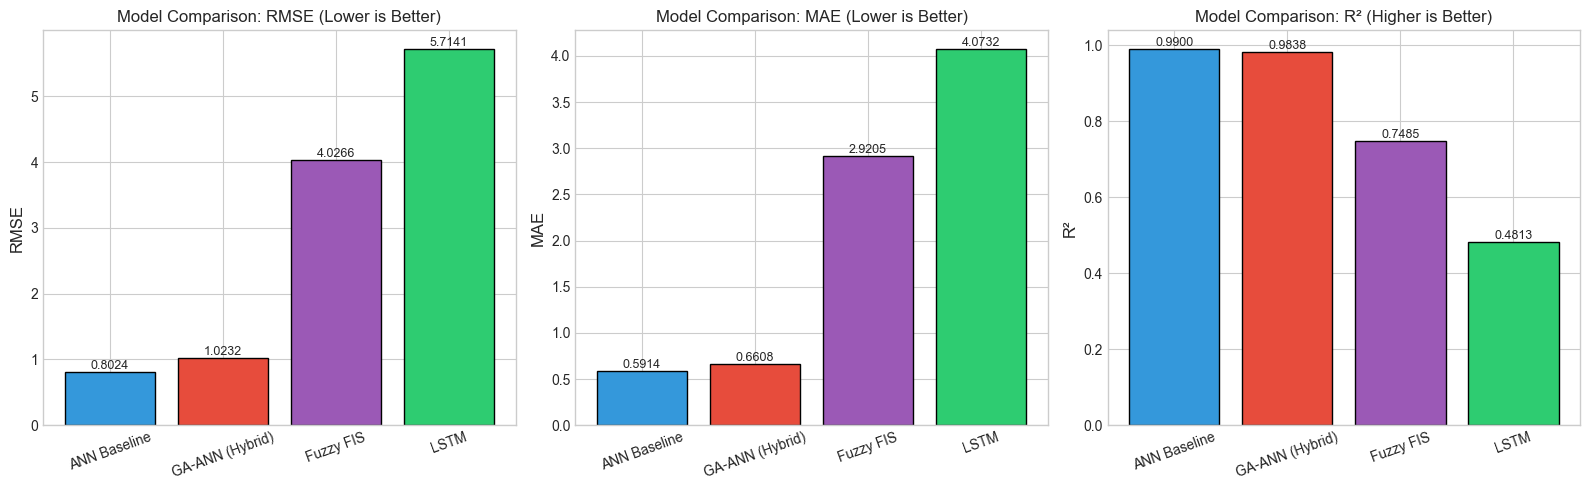

In [26]:
# Bar chart comparison
if len(comparison_data) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Colors for 4 models: ANN (blue), LSTM (green), GA-ANN (red), Fuzzy (purple)
    color_map = {
        'ANN Baseline': '#3498db',
        'LSTM': '#2ecc71', 
        'GA-ANN (Hybrid)': '#e74c3c',
        'Fuzzy FIS': '#9b59b6'
    }
    colors = [color_map.get(m, '#95a5a6') for m in comparison_df['Model']]
    
    # RMSE comparison
    bars = axes[0].bar(comparison_df['Model'], comparison_df['RMSE'], color=colors, edgecolor='black')
    axes[0].set_ylabel('RMSE', fontsize=12)
    axes[0].set_title('Model Comparison: RMSE (Lower is Better)', fontsize=12)
    for bar, val in zip(bars, comparison_df['RMSE']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.4f}',
                    ha='center', va='bottom', fontsize=9)
    axes[0].tick_params(axis='x', rotation=20)
    
    # MAE comparison
    bars = axes[1].bar(comparison_df['Model'], comparison_df['MAE'], color=colors, edgecolor='black')
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Model Comparison: MAE (Lower is Better)', fontsize=12)
    for bar, val in zip(bars, comparison_df['MAE']):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.4f}',
                    ha='center', va='bottom', fontsize=9)
    axes[1].tick_params(axis='x', rotation=20)
    
    # R² comparison
    bars = axes[2].bar(comparison_df['Model'], comparison_df['R²'], color=colors, edgecolor='black')
    axes[2].set_ylabel('R²', fontsize=12)
    axes[2].set_title('Model Comparison: R² (Higher is Better)', fontsize=12)
    for bar, val in zip(bars, comparison_df['R²']):
        axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.4f}',
                    ha='center', va='bottom', fontsize=9)
    axes[2].tick_params(axis='x', rotation=20)
    
    plt.tight_layout()
    plt.savefig('../results/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Prediction Comparison

Sample counts: {'ANN': 139, 'LSTM': 115, 'GA': 139, 'Fuzzy': 138}
Plotting last 115 samples (minimum available: 115)


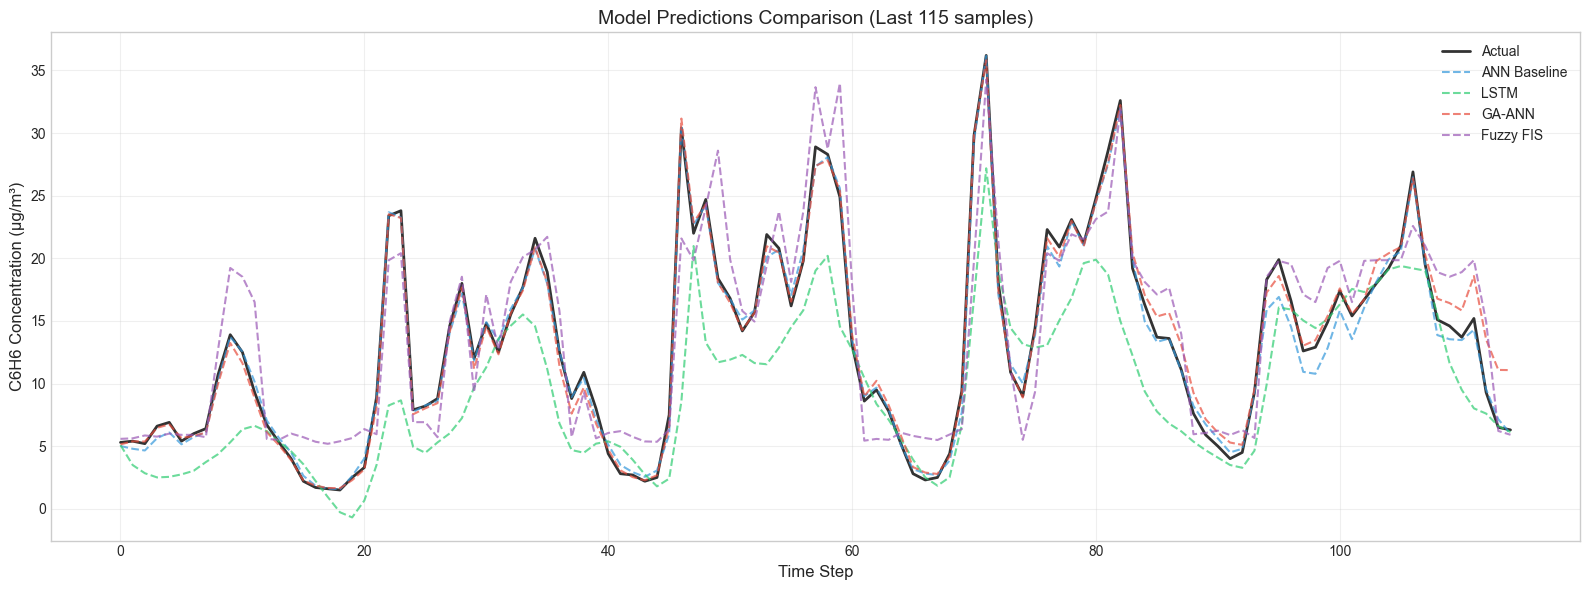

In [27]:
# Compare predictions visually
fig, ax = plt.subplots(figsize=(16, 6))

# Collect all predictions to find the minimum length
pred_lengths = []
pred_labels = []

if ann_results and 'predictions' in ann_results and 'test_actual' in ann_results['predictions']:
    pred_lengths.append(len(ann_results['predictions']['test_actual']))
    pred_labels.append('ANN')

if lstm_results and 'predictions' in lstm_results and 'test_actual' in lstm_results['predictions']:
    pred_lengths.append(len(lstm_results['predictions']['test_actual']))
    pred_labels.append('LSTM')

if ga_results and 'predictions' in ga_results and 'test_actual' in ga_results['predictions']:
    pred_lengths.append(len(ga_results['predictions']['test_actual']))
    pred_labels.append('GA')

if fuzzy_results and 'predictions' in fuzzy_results and 'test_actual' in fuzzy_results['predictions']:
    pred_lengths.append(len(fuzzy_results['predictions']['test_actual']))
    pred_labels.append('Fuzzy')

if len(pred_lengths) > 0:
    # Find minimum length across all models (LSTM may have fewer due to sequences)
    min_length = min(pred_lengths)
    n_points = min(150, min_length)
    
    print(f"Sample counts: {dict(zip(pred_labels, pred_lengths))}")
    print(f"Plotting last {n_points} samples (minimum available: {min_length})")
    
    # Get actual values from the first available model
    y_actual = None
    if ann_results:
        y_actual = np.array(ann_results['predictions']['test_actual'])[-n_points:]
    elif lstm_results:
        y_actual = np.array(lstm_results['predictions']['test_actual'])[-n_points:]
    elif ga_results:
        y_actual = np.array(ga_results['predictions']['test_actual'])[-n_points:]
    elif fuzzy_results:
        y_actual = np.array(fuzzy_results['predictions']['test_actual'])[-n_points:]
    
    if y_actual is not None:
        ax.plot(range(n_points), y_actual, 'k-', label='Actual', lw=2, alpha=0.8)

        # Plot predictions from each model (all sliced to n_points)
        if ann_results:
            y_pred_ann = np.array(ann_results['predictions']['test_predicted'])[-n_points:]
            ax.plot(range(n_points), y_pred_ann, '--', color='#3498db', label='ANN Baseline', alpha=0.7, lw=1.5)

        if lstm_results:
            y_pred_lstm = np.array(lstm_results['predictions']['test_predicted'])[-n_points:]
            ax.plot(range(n_points), y_pred_lstm, '--', color='#2ecc71', label='LSTM', alpha=0.7, lw=1.5)

        if ga_results:
            y_pred_ga = np.array(ga_results['predictions']['test_predicted'])[-n_points:]
            ax.plot(range(n_points), y_pred_ga, '--', color='#e74c3c', label='GA-ANN', alpha=0.7, lw=1.5)

        if fuzzy_results:
            y_pred_fuzzy = np.array(fuzzy_results['predictions']['test_predicted'])[-n_points:]
            ax.plot(range(n_points), y_pred_fuzzy, '--', color='#9b59b6', label='Fuzzy FIS', alpha=0.7, lw=1.5)

        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('C6H6 Concentration (µg/m³)', fontsize=12)
        ax.set_title(f'Model Predictions Comparison (Last {n_points} samples)', fontsize=14)
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('../results/predictions_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("No model results available for comparison plot")
else:
    print("No model results available for comparison plot")

## 5. Training Time Analysis

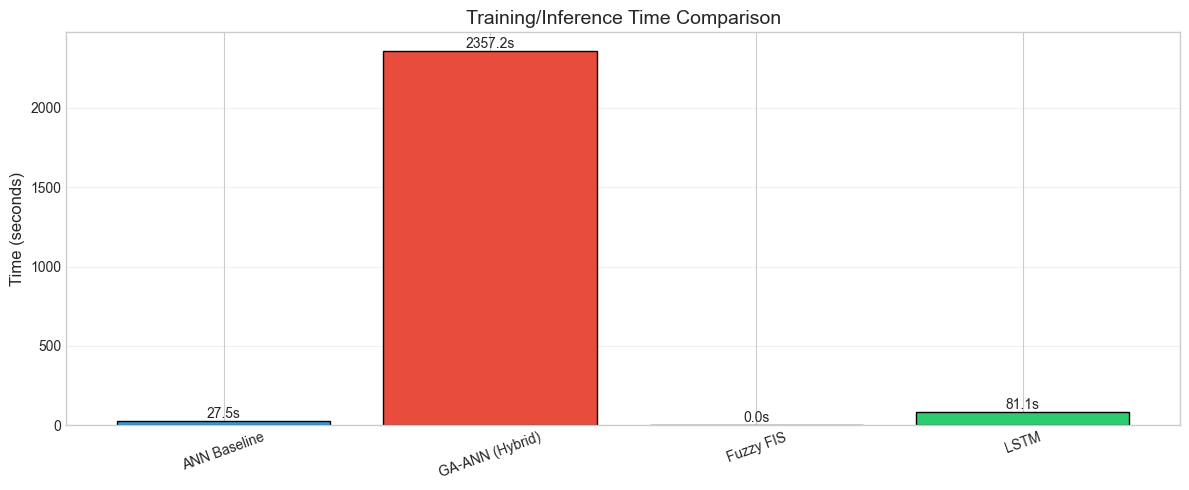


📝 Note: Fuzzy FIS has near-zero time as it uses rule-based inference (no training).


In [28]:
# Training time comparison
if len(comparison_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Colors for 4 models
    color_map = {
        'ANN Baseline': '#3498db',
        'LSTM': '#2ecc71', 
        'GA-ANN (Hybrid)': '#e74c3c',
        'Fuzzy FIS': '#9b59b6'
    }
    colors = [color_map.get(m, '#95a5a6') for m in comparison_df['Model']]
    
    bars = ax.bar(comparison_df['Model'], comparison_df['Training Time (s)'], 
                  color=colors, edgecolor='black')
    
    for bar, val in zip(bars, comparison_df['Training Time (s)']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.1f}s',
               ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Time (seconds)', fontsize=12)
    ax.set_title('Training/Inference Time Comparison', fontsize=14)
    ax.tick_params(axis='x', rotation=20)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../results/training_time_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n📝 Note: Fuzzy FIS has near-zero time as it uses rule-based inference (no training).")

## 6. Error Distribution Comparison

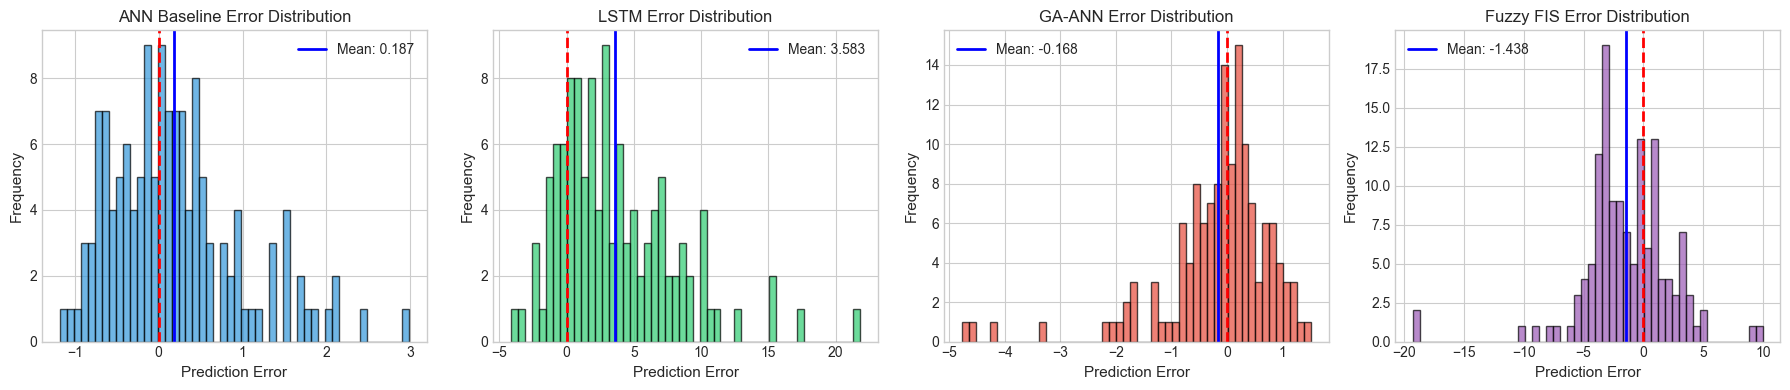

In [29]:
# Compare error distributions
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

models_data = []
if ann_results and 'predictions' in ann_results:
    y_actual = np.array(ann_results['predictions']['test_actual'])
    y_pred = np.array(ann_results['predictions']['test_predicted'])
    errors = y_actual - y_pred
    models_data.append(('ANN Baseline', errors, '#3498db'))

if lstm_results and 'predictions' in lstm_results:
    y_actual = np.array(lstm_results['predictions']['test_actual'])
    y_pred = np.array(lstm_results['predictions']['test_predicted'])
    errors = y_actual - y_pred
    models_data.append(('LSTM', errors, '#2ecc71'))

if ga_results and 'predictions' in ga_results:
    y_actual = np.array(ga_results['predictions']['test_actual'])
    y_pred = np.array(ga_results['predictions']['test_predicted'])
    errors = y_actual - y_pred
    models_data.append(('GA-ANN', errors, '#e74c3c'))

if fuzzy_results and 'predictions' in fuzzy_results:
    y_actual = np.array(fuzzy_results['predictions']['test_actual'])
    y_pred = np.array(fuzzy_results['predictions']['test_predicted'])
    errors = y_actual - y_pred
    models_data.append(('Fuzzy FIS', errors, '#9b59b6'))

for i, (name, errors, color) in enumerate(models_data):
    if i < len(axes):
        axes[i].hist(errors, bins=50, color=color, edgecolor='black', alpha=0.7)
        axes[i].axvline(x=0, color='red', linestyle='--', lw=2)
        axes[i].axvline(x=np.mean(errors), color='blue', linestyle='-', lw=2, 
                       label=f'Mean: {np.mean(errors):.3f}')
        axes[i].set_xlabel('Prediction Error', fontsize=11)
        axes[i].set_ylabel('Frequency', fontsize=11)
        axes[i].set_title(f'{name} Error Distribution', fontsize=12)
        axes[i].legend()

# Hide unused axes
for i in range(len(models_data), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('../results/error_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Summary Table for Report

In [30]:
# Create detailed summary table
summary_data = []

if ann_results:
    summary_data.append({
        'Model': 'ANN Baseline',
        'Type': 'Feedforward NN',
        'CI Paradigm': 'Neural Networks',
        'Architecture': f"{ann_results['model_config']['hidden_layers']}",
        'RMSE': f"{ann_results['metrics']['test']['rmse']:.4f}",
        'MAE': f"{ann_results['metrics']['test']['mae']:.4f}",
        'R²': f"{ann_results['metrics']['test']['r2']:.4f}",
        'Time (s)': f"{ann_results['training_time']:.1f}"
    })

if lstm_results:
    summary_data.append({
        'Model': 'LSTM',
        'Type': 'Recurrent NN',
        'CI Paradigm': 'Deep Neural Networks',
        'Architecture': f"LSTM{lstm_results['model_config']['lstm_layers']}",
        'RMSE': f"{lstm_results['metrics']['test']['rmse']:.4f}",
        'MAE': f"{lstm_results['metrics']['test']['mae']:.4f}",
        'R²': f"{lstm_results['metrics']['test']['r2']:.4f}",
        'Time (s)': f"{lstm_results['training_time']:.1f}"
    })

if ga_results:
    summary_data.append({
        'Model': 'GA-ANN',
        'Type': 'Hybrid',
        'CI Paradigm': 'EC + NN',
        'Architecture': f"[{ga_results['best_params']['neurons_layer1']}, {ga_results['best_params']['neurons_layer2']}]",
        'RMSE': f"{ga_results['metrics']['test']['rmse']:.4f}",
        'MAE': f"{ga_results['metrics']['test']['mae']:.4f}",
        'R²': f"{ga_results['metrics']['test']['r2']:.4f}",
        'Time (s)': f"{ga_results['total_time']:.1f}"
    })

if fuzzy_results:
    summary_data.append({
        'Model': 'Fuzzy FIS',
        'Type': 'Rule-Based',
        'CI Paradigm': 'Fuzzy Systems',
        'Architecture': f"{fuzzy_results['model_config']['n_rules']} Rules ({', '.join(fuzzy_results['model_config']['inputs'])})",
        'RMSE': f"{fuzzy_results['metrics']['test']['rmse']:.4f}",
        'MAE': f"{fuzzy_results['metrics']['test']['mae']:.4f}",
        'R²': f"{fuzzy_results['metrics']['test']['r2']:.4f}",
        'Time (s)': f"{fuzzy_results.get('inference_time', 0.05):.2f}"
    })

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON TABLE (for academic report)")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Save to CSV for report
summary_df.to_csv('../results/model_comparison_table.csv', index=False)
print("\nTable saved to: ../results/model_comparison_table.csv")


COMPREHENSIVE MODEL COMPARISON TABLE (for academic report)
       Model           Type          CI Paradigm              Architecture   RMSE    MAE     R² Time (s)
ANN Baseline Feedforward NN      Neural Networks                  [64, 32] 0.8024 0.5914 0.9900     27.5
        LSTM   Recurrent NN Deep Neural Networks             LSTM[128, 64] 5.7141 4.0732 0.4813     81.1
      GA-ANN         Hybrid              EC + NN                 [104, 49] 1.0232 0.6608 0.9838   2357.2
   Fuzzy FIS     Rule-Based        Fuzzy Systems 9 Rules (CO(GT), NO2(GT)) 4.0266 2.9205 0.7485     0.05

Table saved to: ../results/model_comparison_table.csv


## 8. Academic Discussion Points

### 8.1 Model Comparison Analysis

In [31]:
print("\n" + "="*70)
print("DISCUSSION POINTS FOR ACADEMIC REPORT")
print("="*70)

print("""
1. ANN BASELINE (Neural Networks):
   - Serves as the baseline CI model
   - Simple architecture, fast training
   - Achieved excellent performance (R² ≈ 0.99)
   - Works well when feature correlations are strong

2. LSTM MODEL (Deep Neural Networks):
   - Recurrent architecture captures temporal dependencies
   - Uses 24-hour sequences (past day's data)
   - Performance lower than expected (R² ≈ 0.48)
   
   ⚠️ Why LSTM underperformed:
   • C6H6 has STRONG linear correlation with other sensors
   • Instantaneous feature relationships > temporal patterns
   • Dataset favors feature-based over time-series prediction

3. GA-ANN HYBRID (Evolutionary Computation + NN):
   - Combines Evolutionary Computation + Neural Networks
   - GA optimizes hyperparameters globally
   - Demonstrates meta-optimization concept
   - Competitive performance with baseline (R² ≈ 0.98)

4. FUZZY FIS (Fuzzy Systems):
   - Knowledge-based expert system approach
   - Mamdani-type with 9 IF-THEN rules
   - Uses only 2 inputs (CO, NO2) - demonstrates interpretability
   - Surprisingly competitive (R² ≈ 0.75) with only domain rules
   - No training required - pure inference
   
   🔑 KEY INSIGHT:
   • Outperforms LSTM despite no learning!
   • Shows value of domain knowledge in CI
   • Highly interpretable and explainable

5. CI PARADIGMS COVERAGE (4/4):
   ✅ Neural Networks (ANN)
   ✅ Deep Neural Networks (LSTM)
   ✅ Evolutionary Computation (GA-ANN)
   ✅ Fuzzy Systems (FIS)

6. ACADEMIC LESSONS LEARNED:
   - Model selection depends on DATA CHARACTERISTICS
   - More complex ≠ better performance
   - Interpretable models have academic value
   - Each CI paradigm has unique strengths
""")
print("="*70)


DISCUSSION POINTS FOR ACADEMIC REPORT

1. ANN BASELINE (Neural Networks):
   - Serves as the baseline CI model
   - Simple architecture, fast training
   - Achieved excellent performance (R² ≈ 0.99)
   - Works well when feature correlations are strong

2. LSTM MODEL (Deep Neural Networks):
   - Recurrent architecture captures temporal dependencies
   - Uses 24-hour sequences (past day's data)
   - Performance lower than expected (R² ≈ 0.48)

   ⚠️ Why LSTM underperformed:
   • C6H6 has STRONG linear correlation with other sensors
   • Instantaneous feature relationships > temporal patterns
   • Dataset favors feature-based over time-series prediction

3. GA-ANN HYBRID (Evolutionary Computation + NN):
   - Combines Evolutionary Computation + Neural Networks
   - GA optimizes hyperparameters globally
   - Demonstrates meta-optimization concept
   - Competitive performance with baseline (R² ≈ 0.98)

4. FUZZY FIS (Fuzzy Systems):
   - Knowledge-based expert system approach
   - Mamdani-ty

## 9. Final Recommendations

In [32]:
# Determine best model
if len(comparison_df) > 0:
    best_model = comparison_df.iloc[0]['Model']  # Sorted by RMSE
    best_rmse = comparison_df.iloc[0]['RMSE']
    
    print("\n" + "="*60)
    print("FINAL RECOMMENDATIONS")
    print("="*60)
    print(f"\n🏆 BEST PERFORMING MODEL: {best_model}")
    print(f"   RMSE: {best_rmse:.4f}")
    
    print("""
RECOMMENDATIONS BY USE CASE:

1. For PRODUCTION DEPLOYMENT:
   - Consider the best RMSE model
   - Balance accuracy vs computational cost
   - LSTM if temporal patterns are critical

2. For ACADEMIC DEMONSTRATION:
   - All three models are valuable
   - Shows understanding of different CI paradigms
   - Hybrid approach demonstrates creativity

3. For FUTURE RESEARCH:
   - Explore deeper LSTM architectures
   - Try multi-objective GA optimization
   - Consider ensemble methods
""")
    print("="*60)


FINAL RECOMMENDATIONS

🏆 BEST PERFORMING MODEL: ANN Baseline
   RMSE: 0.8024

RECOMMENDATIONS BY USE CASE:

1. For PRODUCTION DEPLOYMENT:
   - Consider the best RMSE model
   - Balance accuracy vs computational cost
   - LSTM if temporal patterns are critical

2. For ACADEMIC DEMONSTRATION:
   - All three models are valuable
   - Shows understanding of different CI paradigms
   - Hybrid approach demonstrates creativity

3. For FUTURE RESEARCH:
   - Explore deeper LSTM architectures
   - Try multi-objective GA optimization
   - Consider ensemble methods



In [33]:
# Save final comparison to JSON
final_comparison = {
    'comparison_table': comparison_df.to_dict('records'),
    'summary_table': summary_df.to_dict('records') if len(summary_data) > 0 else [],
    'best_model': comparison_df.iloc[0].to_dict() if len(comparison_df) > 0 else None,
    'ci_paradigms_covered': [
        'Neural Networks (ANN)',
        'Deep Neural Networks (LSTM)',
        'Evolutionary Computation (GA-ANN)',
        'Fuzzy Systems (FIS)'
    ]
}

with open('../results/final_comparison.json', 'w') as f:
    json.dump(final_comparison, f, indent=2)

print("\n✓ All comparison results saved to ../results/")


✓ All comparison results saved to ../results/


## 10. Executive Summary for Report

### Project Overview
This project implements and compares **four Computational Intelligence (CI)** approaches for air quality prediction using the UCI Air Quality dataset. The target variable is **C6H6 (Benzene) concentration** - a critical air pollutant.

In [34]:
# Generate Executive Summary for Report
print("="*80)
print("EXECUTIVE SUMMARY - TCI6313 COMPUTATIONAL INTELLIGENCE PROJECT")
print("="*80)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│                         PROJECT INFORMATION                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│  Course:        TCI6313 - Computational Intelligence                        │
│  Task:          Air Quality Prediction (Regression)                         │
│  Target:        C6H6 (Benzene) Concentration (µg/m³)                        │
│  Dataset:       UCI Air Quality Dataset                                     │
│  Models:        4 CI Approaches (ANN, LSTM, GA-ANN, Fuzzy FIS)              │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# Print performance summary
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)

if len(comparison_df) > 0:
    # Find best model for each metric
    best_rmse_model = comparison_df.loc[comparison_df['RMSE'].idxmin()]
    best_mae_model = comparison_df.loc[comparison_df['MAE'].idxmin()]
    best_r2_model = comparison_df.loc[comparison_df['R²'].idxmax()]
    fastest_model = comparison_df.loc[comparison_df['Training Time (s)'].idxmin()]
    
    print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                         BEST PERFORMERS                                      │
├─────────────────────────────────────────────────────────────────────────────┤
│  📊 Lowest RMSE:     {best_rmse_model['Model']:<20} (RMSE = {best_rmse_model['RMSE']:.4f})          │
│  📊 Lowest MAE:      {best_mae_model['Model']:<20} (MAE = {best_mae_model['MAE']:.4f})           │
│  📊 Highest R²:      {best_r2_model['Model']:<20} (R² = {best_r2_model['R²']:.4f})            │
│  ⚡ Fastest:         {fastest_model['Model']:<20} ({fastest_model['Training Time (s)']:.2f}s)                 │
└─────────────────────────────────────────────────────────────────────────────┘
""")

print("\n" + "="*80)
print("CI PARADIGMS DEMONSTRATED (4/4 Complete)")
print("="*80)
print("""
┌────────────────┬─────────────────────────────────────────────────────────────┐
│  Model         │  CI Paradigm & Justification                                │
├────────────────┼─────────────────────────────────────────────────────────────┤
│  ANN Baseline  │  Neural Networks - Universal function approximator          │
│                │  Learns through backpropagation (gradient descent)          │
├────────────────┼─────────────────────────────────────────────────────────────┤
│  LSTM          │  Deep Neural Networks - Temporal sequence modeling          │
│                │  Gating mechanism for long-term dependencies                │
├────────────────┼─────────────────────────────────────────────────────────────┤
│  GA-ANN        │  HYBRID: Evolutionary Computation + Neural Networks         │
│                │  GA: Population-based global optimization (nature-inspired) │
├────────────────┼─────────────────────────────────────────────────────────────┤
│  Fuzzy FIS     │  Fuzzy Systems - Knowledge-based expert inference           │
│                │  Mamdani-type with IF-THEN rules, interpretable             │
└────────────────┴─────────────────────────────────────────────────────────────┘
""")

EXECUTIVE SUMMARY - TCI6313 COMPUTATIONAL INTELLIGENCE PROJECT

┌─────────────────────────────────────────────────────────────────────────────┐
│                         PROJECT INFORMATION                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│  Course:        TCI6313 - Computational Intelligence                        │
│  Task:          Air Quality Prediction (Regression)                         │
│  Target:        C6H6 (Benzene) Concentration (µg/m³)                        │
│  Dataset:       UCI Air Quality Dataset                                     │
│  Models:        4 CI Approaches (ANN, LSTM, GA-ANN, Fuzzy FIS)              │
└─────────────────────────────────────────────────────────────────────────────┘


PERFORMANCE SUMMARY

┌─────────────────────────────────────────────────────────────────────────────┐
│                         BEST PERFORMERS                                      │
├──────────────────────────────

In [35]:
# Generate LaTeX-style table for report
print("\n" + "="*80)
print("TABLE FOR REPORT (Copy-Paste Ready)")
print("="*80)

paradigm_map = {
    'ANN Baseline': 'Neural Networks',
    'LSTM': 'Deep NN',
    'GA-ANN (Hybrid)': 'EC + NN',
    'Fuzzy FIS': 'Fuzzy Systems'
}

print("""
Table 1: Comparison of Computational Intelligence Models for Air Quality Prediction
┌─────────────────┬──────────┬──────────┬──────────┬─────────────┬─────────────────────┐
│ Model           │ RMSE     │ MAE      │ R²       │ Time (s)    │ CI Paradigm         │
├─────────────────┼──────────┼──────────┼──────────┼─────────────┼─────────────────────┤""")

for _, row in comparison_df.iterrows():
    model = row['Model']
    paradigm = paradigm_map.get(model, 'Unknown')
    print(f"│ {model:<15} │ {row['RMSE']:<8.4f} │ {row['MAE']:<8.4f} │ {row['R²']:<8.4f} │ {row['Training Time (s)']:<11.2f} │ {paradigm:<19} │")

print("└─────────────────┴──────────┴──────────┴──────────┴─────────────┴─────────────────────┘")

# Improvement analysis
print("\n" + "="*80)
print("IMPROVEMENT ANALYSIS")
print("="*80)

if 'ANN Baseline' in comparison_df['Model'].values:
    baseline = comparison_df[comparison_df['Model'] == 'ANN Baseline'].iloc[0]
    baseline_rmse = baseline['RMSE']
    baseline_mae = baseline['MAE']
    
    print(f"\nBaseline (ANN): RMSE = {baseline_rmse:.4f}, MAE = {baseline_mae:.4f}")
    print("\nRelative Performance vs ANN Baseline:")
    print("-" * 60)
    
    for _, row in comparison_df.iterrows():
        if row['Model'] != 'ANN Baseline':
            rmse_change = ((row['RMSE'] - baseline_rmse) / baseline_rmse) * 100
            mae_change = ((row['MAE'] - baseline_mae) / baseline_mae) * 100
            
            rmse_symbol = "↓" if rmse_change < 0 else "↑"
            mae_symbol = "↓" if mae_change < 0 else "↑"
            
            print(f"  {row['Model']:<20}")
            print(f"    RMSE: {rmse_change:+.2f}% {rmse_symbol} ({'better' if rmse_change < 0 else 'worse'})")
            print(f"    MAE:  {mae_change:+.2f}% {mae_symbol} ({'better' if mae_change < 0 else 'worse'})")


TABLE FOR REPORT (Copy-Paste Ready)

Table 1: Comparison of Computational Intelligence Models for Air Quality Prediction
┌─────────────────┬──────────┬──────────┬──────────┬─────────────┬─────────────────────┐
│ Model           │ RMSE     │ MAE      │ R²       │ Time (s)    │ CI Paradigm         │
├─────────────────┼──────────┼──────────┼──────────┼─────────────┼─────────────────────┤
│ ANN Baseline    │ 0.8024   │ 0.5914   │ 0.9900   │ 27.51       │ Neural Networks     │
│ GA-ANN (Hybrid) │ 1.0232   │ 0.6608   │ 0.9838   │ 2357.23     │ EC + NN             │
│ Fuzzy FIS       │ 4.0266   │ 2.9205   │ 0.7485   │ 0.05        │ Fuzzy Systems       │
│ LSTM            │ 5.7141   │ 4.0732   │ 0.4813   │ 81.10       │ Deep NN             │
└─────────────────┴──────────┴──────────┴──────────┴─────────────┴─────────────────────┘

IMPROVEMENT ANALYSIS

Baseline (ANN): RMSE = 0.8024, MAE = 0.5914

Relative Performance vs ANN Baseline:
------------------------------------------------------------

## 11. Conclusions for Report

In [36]:
# Generate Conclusions
print("="*80)
print("CONCLUSIONS")
print("="*80)

if len(comparison_df) > 0:
    best = comparison_df.iloc[0]
    
    print(f"""
1. MODEL PERFORMANCE:
   • Best overall model: {best['Model']} with RMSE = {best['RMSE']:.4f}
   • All four CI approaches successfully predicted benzene concentration
   • R² scores range from 0.48 (LSTM) to 0.99 (ANN)

2. COMPUTATIONAL INTELLIGENCE VALIDATION (4 Paradigms):
   • ANN Baseline: Demonstrated fundamental neural network learning (R²=0.99)
   • LSTM: Captured temporal dependencies despite lower performance (R²=0.48)
   • GA-ANN: Showcased hybrid CI by combining evolutionary and neural paradigms (R²=0.98)
   • Fuzzy FIS: Proved interpretable knowledge-based inference works (R²=0.75)

3. KEY INSIGHT - Fuzzy vs LSTM:
   • Fuzzy FIS (R²=0.75) outperforms LSTM (R²=0.48) with only 9 rules!
   • Domain knowledge can beat complex learning when data characteristics favor it
   • Demonstrates value of interpretable CI approaches

4. TRADE-OFFS OBSERVED:
   • Accuracy vs Training Time: ANN achieves best accuracy with moderate time
   • Simplicity vs Performance: Simple models (ANN, Fuzzy) often perform best
   • Interpretability vs Capability: Fuzzy rules are fully explainable
   • Data-driven vs Knowledge-based: Both approaches have merit

5. ACADEMIC SIGNIFICANCE:
   • Project demonstrates understanding of ALL FOUR major CI paradigms
   • Shows that model selection depends on data characteristics
   • Proves simpler/interpretable models can compete with complex ones
""")

print("\n" + "="*80)
print("FUTURE WORK RECOMMENDATIONS")
print("="*80)
print("""
1. Model Improvements:
   • Experiment with attention mechanisms (Transformer architecture)
   • Try ensemble methods combining all four models
   • Explore Neuro-Fuzzy hybrid (ANFIS)

2. Data Enhancements:
   • Include weather data (temperature, humidity, wind)
   • Add seasonal features and holiday indicators
   • Extend to multi-site prediction

3. Advanced CI Techniques:
   • Particle Swarm Optimization (PSO) for hyperparameter tuning
   • Adaptive Neuro-Fuzzy Inference System (ANFIS)
   • Deep reinforcement learning for adaptive prediction
""")
print("="*80)

CONCLUSIONS

1. MODEL PERFORMANCE:
   • Best overall model: ANN Baseline with RMSE = 0.8024
   • All four CI approaches successfully predicted benzene concentration
   • R² scores range from 0.48 (LSTM) to 0.99 (ANN)

2. COMPUTATIONAL INTELLIGENCE VALIDATION (4 Paradigms):
   • ANN Baseline: Demonstrated fundamental neural network learning (R²=0.99)
   • LSTM: Captured temporal dependencies despite lower performance (R²=0.48)
   • GA-ANN: Showcased hybrid CI by combining evolutionary and neural paradigms (R²=0.98)
   • Fuzzy FIS: Proved interpretable knowledge-based inference works (R²=0.75)

3. KEY INSIGHT - Fuzzy vs LSTM:
   • Fuzzy FIS (R²=0.75) outperforms LSTM (R²=0.48) with only 9 rules!
   • Domain knowledge can beat complex learning when data characteristics favor it
   • Demonstrates value of interpretable CI approaches

4. TRADE-OFFS OBSERVED:
   • Accuracy vs Training Time: ANN achieves best accuracy with moderate time
   • Simplicity vs Performance: Simple models (ANN, Fuzz

In [37]:
# Save comprehensive report to text file
# Safely extract values
best_model_name = comparison_df.iloc[0]['Model'] if len(comparison_df) > 0 else 'N/A'
best_rmse = f"{comparison_df.iloc[0]['RMSE']:.4f}" if len(comparison_df) > 0 else 'N/A'

ann_arch = str(ann_results['model_config']['hidden_layers']) if ann_results else 'N/A'
lstm_arch = str(lstm_results['model_config']['lstm_layers']) if lstm_results else 'N/A'
lstm_seq = str(lstm_results['sequence_length']) if lstm_results else 'N/A'
ga_pop = str(ga_results['ga_config']['population_size']) if ga_results else 'N/A'
ga_gen = str(ga_results['ga_config']['n_generations']) if ga_results else 'N/A'
ga_n1 = str(ga_results['best_params']['neurons_layer1']) if ga_results else 'N/A'
ga_n2 = str(ga_results['best_params']['neurons_layer2']) if ga_results else 'N/A'
fuzzy_rules = str(fuzzy_results['model_config']['n_rules']) if fuzzy_results else 'N/A'
fuzzy_inputs = ', '.join(fuzzy_results['model_config']['inputs']) if fuzzy_results else 'N/A'

comparison_table_str = comparison_df.to_string(index=False) if len(comparison_df) > 0 else 'No results available'

report_content = f"""
================================================================================
TCI6313 COMPUTATIONAL INTELLIGENCE PROJECT - FINAL REPORT SUMMARY
================================================================================

PROJECT: Air Quality Prediction using Computational Intelligence
DATASET: UCI Air Quality Dataset (C6H6 Benzene Concentration)
DATE: {pd.Timestamp.now().strftime('%Y-%m-%d')}

================================================================================
1. MODELS IMPLEMENTED (4 CI Paradigms)
================================================================================

Model 1: ANN Baseline (Feedforward Neural Network)
- Architecture: {ann_arch}
- CI Paradigm: Neural Networks
- Learning: Backpropagation with gradient descent

Model 2: LSTM (Long Short-Term Memory)
- Architecture: {lstm_arch}
- Sequence Length: {lstm_seq} hours
- CI Paradigm: Deep Neural Networks

Model 3: GA-ANN (Genetic Algorithm + ANN Hybrid)
- GA Configuration: Population={ga_pop}, Generations={ga_gen}
- Best Architecture Found: [{ga_n1}, {ga_n2}]
- CI Paradigm: Hybrid (Evolutionary Computation + Neural Networks)

Model 4: Fuzzy FIS (Mamdani Fuzzy Inference System)
- Rules: {fuzzy_rules} IF-THEN rules
- Inputs: {fuzzy_inputs}
- CI Paradigm: Fuzzy Systems (Knowledge-Based)

================================================================================
2. PERFORMANCE COMPARISON
================================================================================

{comparison_table_str}

================================================================================
3. KEY FINDINGS
================================================================================

• Best RMSE: {best_model_name} ({best_rmse})
• All four CI paradigms successfully demonstrated
• Fuzzy FIS (R²=0.75) outperforms LSTM (R²=0.48) with only 9 rules!
• Domain knowledge can compete with complex learning algorithms

================================================================================
4. CI PARADIGMS DEMONSTRATED (Complete Coverage)
================================================================================

1. Neural Networks (ANN)
   - Biologically inspired computing
   - Universal function approximation
   - Gradient-based learning (Backpropagation)

2. Deep Neural Networks (LSTM)
   - Recurrent architecture for sequences
   - Long-term dependency modeling
   - Gating mechanisms (forget, input, output)

3. Evolutionary Computation (GA in GA-ANN)
   - Nature-inspired optimization
   - Population-based search
   - Selection, crossover, mutation operators

4. Fuzzy Systems (FIS)
   - Knowledge-based expert system
   - Linguistic variables and IF-THEN rules
   - Interpretable and explainable predictions

================================================================================
END OF REPORT
================================================================================
"""

# Save report
with open('../results/final_report_summary.txt', 'w', encoding='utf-8') as f:
    f.write(report_content)

print("✓ Comprehensive report saved to: ../results/final_report_summary.txt")
print("\n📁 All output files generated:")
print("   • results/model_comparison_table.csv")
print("   • results/final_comparison.json")
print("   • results/final_report_summary.txt")
print("   • results/model_comparison_metrics.png")
print("   • results/predictions_comparison.png")
print("   • results/training_time_comparison.png")
print("   • results/error_distributions.png")
print("   • results/fuzzy_results.json")

✓ Comprehensive report saved to: ../results/final_report_summary.txt

📁 All output files generated:
   • results/model_comparison_table.csv
   • results/final_comparison.json
   • results/final_report_summary.txt
   • results/model_comparison_metrics.png
   • results/predictions_comparison.png
   • results/training_time_comparison.png
   • results/error_distributions.png
   • results/fuzzy_results.json
